## **Telecom Customer Churn Prediction**

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

###DATA LOADING & EXPLORATION

In [127]:
df = pd.read_csv('TelecomCustomerChurn.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(df.head())
print(df.info())
print("\nChurn distribution:")
print(df['Churn'].value_counts(normalize=True) * 100)


Dataset loaded: 7043 rows, 21 columns
   customerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

  MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0            No             DSL             No  ...               No   
1            No             DSL            Yes  ...              Yes   
2            No             DSL            Yes  ...               No   
3            No             DSL            Yes  ...              Yes   
4            No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies  Contr

###DATA PREPROCESSING

In [128]:
y = df['Churn']
X = df.drop(['customerID', 'Churn'], axis=1)

# Fill missing values (numeric)
if X.isna().sum().sum() > 0:
    X = X.fillna(X.median(numeric_only=True))

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[categorical_cols] = oe.fit_transform(X[categorical_cols])

# Save cleaned dataset
cleaned_df = pd.concat([X, y], axis=1)
cleaned_df.to_csv('Telecom_Customer_Churn.csv', index=False)
print("✅ Cleaned dataset saved as 'Telecom_Customer_Churn.csv'")


✅ Cleaned dataset saved as 'Telecom_Customer_Churn.csv'


###FEATURE ENGINEERING

In [129]:
print(f"Before SMOTE: {y.value_counts().to_dict()}")
smote = SMOTE(random_state=2529, k_neighbors=5)
X_bal, y_bal = smote.fit_resample(X, y)
print(f"After SMOTE: {y_bal.value_counts().to_dict()}")

# Encode the balanced target variable to numerical values
y_bal_encoded = y_bal.apply(lambda x: 1 if x == 'Yes' else 0)

Before SMOTE: {'No': 5174, 'Yes': 1869}
After SMOTE: {'No': 5174, 'Yes': 5174}


###TRAIN-TEST SPLIT

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal_encoded, test_size=0.25, random_state=2529, stratify=y_bal_encoded
)

###MODEL TRAINING & EVALUATION

In [131]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=2529),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=2529)
}

results = {}

for name, model in models.items():
    print(f"\n{name.upper()}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) # Corrected this line to predict on X_test
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}, CV Mean: {cv_scores.mean():.4f}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    results[name] = {'model': model, 'accuracy': accuracy, 'roc_auc': roc_auc, 'cv_mean': cv_scores.mean()}


LOGISTIC REGRESSION
Accuracy: 0.7704, ROC-AUC: 0.8495, CV Mean: 0.7754
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1294
           1       0.75      0.80      0.78      1293

    accuracy                           0.77      2587
   macro avg       0.77      0.77      0.77      2587
weighted avg       0.77      0.77      0.77      2587

Confusion Matrix:
[[ 954  340]
 [ 254 1039]]

RANDOM FOREST
Accuracy: 0.8481, ROC-AUC: 0.9301, CV Mean: 0.8567
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1294
           1       0.87      0.81      0.84      1293

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587

Confusion Matrix:
[[1142  152]
 [ 241 1052]]


###FEATURE IMPORTANCE (Random Forest)

In [132]:
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Features by Importance:")
print(feature_importance.head(10))


Top 10 Features by Importance:
             Feature  Importance
14          Contract    0.160528
4             Tenure    0.129315
17    MonthlyCharges    0.123537
18      TotalCharges    0.104019
15  PaperlessBilling    0.068230
7    InternetService    0.047939
8     OnlineSecurity    0.047159
11       TechSupport    0.044089
2            Partner    0.043532
3         Dependents    0.040010


###MODEL COMPARISON

In [133]:
comparison_df = pd.DataFrame(results).T[['accuracy', 'roc_auc', 'cv_mean']]
comparison_df.columns = ['Accuracy', 'ROC-AUC', 'CV Mean']
print("\n", comparison_df.to_string())

best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🏆 Best Performing Model: {best_model[0]}")
print(f"   Accuracy: {best_model[1]['accuracy']*100:.2f}%")


                      Accuracy   ROC-AUC   CV Mean
Logistic Regression   0.77039  0.849496  0.775415
Random Forest        0.848087  0.930135  0.856718

🏆 Best Performing Model: Random Forest
   Accuracy: 84.81%


### VISUALIZATION EXAMPLES

### ROC Curve

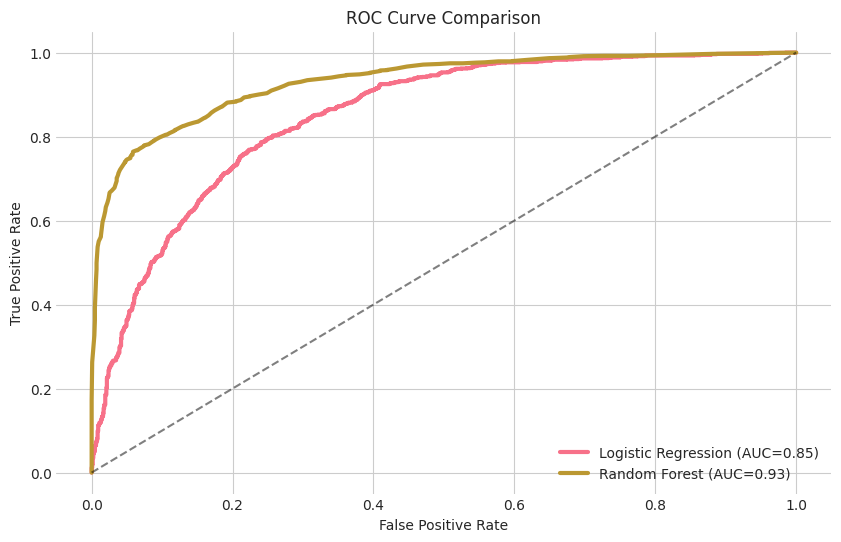

In [134]:
plt.figure(figsize=(10, 6))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['model'].predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.2f})", linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Feature importance bar plot

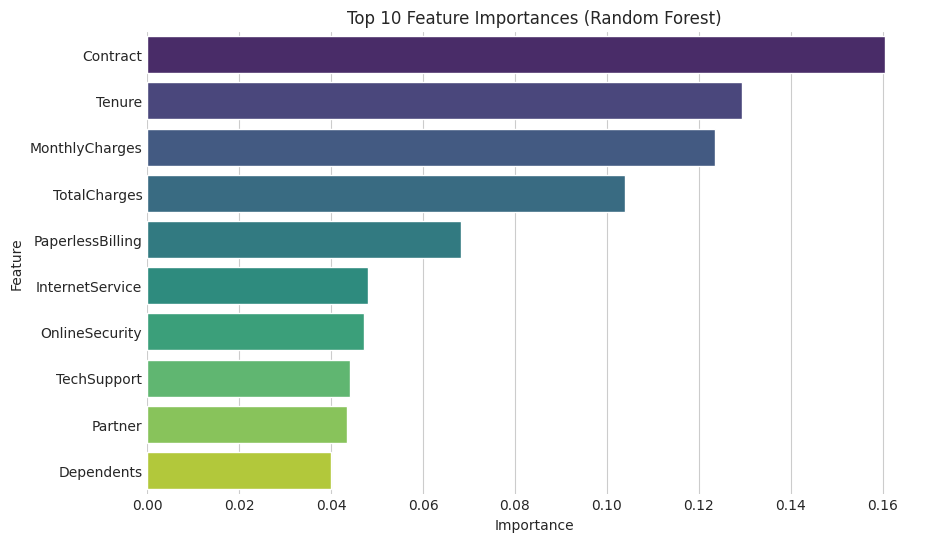

In [135]:
top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()